In [1]:
from osgeo import gdal, ogr
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans


In [4]:
#set path to image
path="mask_spam2017V2r1_SSA_A_COCO_A.tif"
path2="spam2017V2r1_SSA_A_COCO_A.tif"


Define Fuction for Reprojection and Conversion

In [ ]:
-t_srs

In [25]:
def read_transform(path, EPSGCODE):
    output="Temp.tif"
    Transform = gdal.Warp(output, path, dstSRS=EPSGCODE)
    To_Array = Transform.ReadAsArray()

    return Transform, To_Array
    

In [26]:
EPSGCODE = 'EPSG:3857'

In [91]:
raster, Array =read_transform(path, EPSGCODE)

In [92]:
raster

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fe7226c4bd0> >

In [93]:
Array

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

Test if it Works!

In [94]:
test_crs = GDAL.GetProjection()
test_crs

'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'

Plot

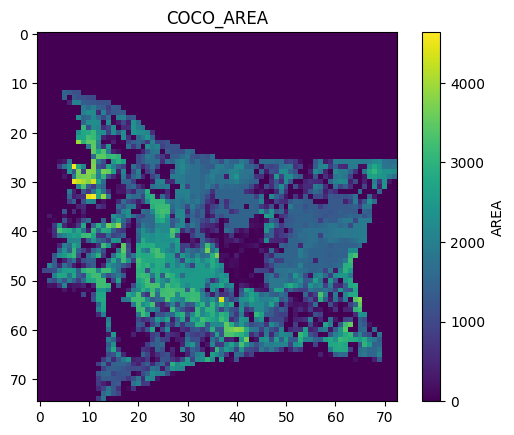

In [95]:
# Plot the raster data using matplotlib
plt.imshow(Array, cmap='viridis')
plt.title('COCO_AREA')
plt.colorbar(label='AREA')
plt.show()


GDAL To Rasterio Conversion !

In [16]:
def gdal_to_rasterio(gdal_ds):
    
    # Read the data and metadata
    data = gdal_ds.ReadAsArray()
    geo_transform = gdal_ds.GetGeoTransform()
    projection = gdal_ds.GetProjection()

    # Get the dimensions of the raster
    cols = gdal_ds.RasterXSize
    rows = gdal_ds.RasterYSize

    # Calculate the affine transformation matrix for rasterio
    transform = rasterio.transform.from_origin(geo_transform[0], geo_transform[3], geo_transform[1], geo_transform[5])

    # Create the rasterio dataset in memory
    memfile = MemoryFile()
    with memfile.open(driver='GTiff', width=cols, height=rows, count=1,
                      dtype=data.dtype, crs=projection,
                      transform=transform) as dst:
        dst.write(data, 1)

    # Close the GDAL dataset
    gdal_ds = None
    
    # Return the rasterio dataset
    return memfile.open()

In [19]:

rasterio_ds = gdal_to_rasterio(test)


In [20]:
rasterio_ds

<open DatasetReader name='/vsimem/54297bf6-02c0-4501-bd0d-a2eca505783e/54297bf6-02c0-4501-bd0d-a2eca505783e.tif' mode='r'>

Check it again

In [32]:
def get_raster_specs(src):
    specs = {
        'crs': src.crs,
        'extent': src.bounds,
        'pixel_size': src.res,
        'width': src.width,
        'height': src.height,
        'count': src.count,
        "Driver:": src.driver,
        "Mode:": src.mode,
        "Is closed?": src.closed,
        "Data types:": src.dtypes,
        "Transform:": src.transform,
        "Block shapes:": src.block_shapes,
        "Nodata values:": src.nodata,
        "Indexes:": src.indexes,
        "Descriptions:": src.descriptions,
        "Tags:": src.tags(),
        "Color interpretation:": src.colorinterp,
        "CRS:": src.crs,
        #"CRS WKT:": src.crs_wkt,
        #"CRS Proj4:": src.crs_proj,
        "Transform:": src.transform
    }
    return specs

def get_proj(src):
    specs = {
        'crs': src.crs,
    }
    return specs

In [33]:
raster_specs = get_raster_specs(rasterio_ds)
print(raster_specs)

{'crs': CRS.from_epsg(3857), 'extent': BoundingBox(left=-955568.6240397836, bottom=1893417.1629097178, right=-275155.7938140526, top=1194362.885280542), 'pixel_size': (9320.723701722343, 9320.723701722343), 'width': 73, 'height': 75, 'count': 1, 'Driver:': 'GTiff', 'Mode:': 'r', 'Is closed?': False, 'Data types:': ('float32',), 'Transform:': Affine(9320.723701722343, 0.0, -955568.6240397836,
       0.0, 9320.723701722343, 1194362.885280542), 'Block shapes:': [(28, 73)], 'Nodata values:': None, 'Indexes:': (1,), 'Descriptions:': (None,), 'Tags:': {'AREA_OR_POINT': 'Area'}, 'Color interpretation:': (<ColorInterp.gray: 1>,), 'CRS:': CRS.from_epsg(3857)}


In [ ]:
def get_top_vals(top_vals=10):
    def largest_indices(ary, n):
        """Returns the n largest indices from a numpy array."""
        flat = ary.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, ary.shape)

    sub_data = data
    index_array = largest_indices(sub_data, top_vals)
    print(f'top {top_vals} values: \n{sub_data[index_array]} \nat indices \n{index_array}')
    

In [77]:
def get_top_vals(data,top_vals=10):
    def largest_indices(ary, n):
        """Returns the n largest indices from a numpy array."""
        flat = ary.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, ary.shape)

    sub_data = data
    index_array = largest_indices(sub_data, top_vals)
    #print(f'top {top_vals} values: \n{sub_data[index_array]} \nat indices \n{index_array}')
    top_values = data[index_array]
    indices = tuple(index_array) 
    return top_values, indices
  

In [78]:
top_vals, indices=get_top_vals(Array)


In [79]:
top_vals

array([4640.7, 4553. , 4512.4, 4423. , 4371. , 4342.5, 4216. , 4012. ,
       3937. , 3910.9], dtype=float32)

In [80]:
indices

(array([33, 27, 30, 33, 54, 30, 30, 30, 22, 33]),
 array([11,  7,  7, 10, 37, 11,  8,  9,  8, 13]))

In [81]:

def get_centroids_geotiff(dataset):
 
    # Get the geotransform parameters
    geotransform = dataset.GetGeoTransform()
    top_left_x, pixel_width, _, top_left_y, _, pixel_height = geotransform

    # Get number of rows and columns 
    rows, cols = dataset.RasterYSize, dataset.RasterXSize

    # lists to store centroid coordinates
    centroids_x = []
    centroids_y = []

    # Calculate centroids for each pixel
    for i in range(rows):
        for j in range(cols):
            centroid_x = top_left_x + j * pixel_width + pixel_width / 2.0
            centroid_y = top_left_y + i * pixel_height + pixel_height / 2.0
            centroids_x.append(centroid_x)
            centroids_y.append(centroid_y)

    # Convert to NumPy arrays
    centroids_x = np.array(centroids_x)
    centroids_y = np.array(centroids_y)

    # Create a DataFrame
    df = pd.DataFrame({'Centroid_X': centroids_x, 'Centroid_Y': centroids_y})

    dataset = None

    return df


In [105]:
centroids = get_centroids_geotiff(raster)
centroids

,Centroid_X,Centroid_Y
0,-950908.262189,1.189703e+06
1,-941587.538487,1.189703e+06
2,-932266.814785,1.189703e+06
3,-922946.091084,1.189703e+06
4,-913625.367382,1.189703e+06
...,...,...
5470,-317099.050472,4.999690e+05
5471,-307778.326770,4.999690e+05
5472,-298457.603068,4.999690e+05
5473,-289136.879367,4.999690e+05


In [104]:
def Find_Values(dataset, top_vals, indices):
    # Get the geotransform parameters
    geotransform = dataset.GetGeoTransform()

    # Call the original function to get all centroids
    all_centroids_df = get_centroids_geotiff(dataset)

    # Extract centroids for specified pixel indices
    specified_centroids_df = all_centroids_df.iloc[indices[0], indices[1]]

    return specified_centroids_df

In [83]:



best_10 = Find_Values(GDAL,top_vals, indices)


IndexError: positional indexers are out-of-bounds

In [65]:
indices[0]

array([33, 27, 30, 33, 54, 30, 30, 30, 22, 33])

In [66]:
specified_centroids_df = all_centroids_df.iloc[indices[0], indices[1]]

NameError: name 'all_centroids_df' is not defined

In [67]:


# Get the geotransform parameters
geotransform = dataset.GetGeoTransform()

# Call the original function to get all centroids
all_centroids_df = get_centroids_geotiff(dataset)

# Extract centroids for specified pixel indices
specified_centroids_df = all_centroids_df.iloc[indices[0], indices[1]]

return specified_centroids_df

NameError: name 'dataset' is not defined

In [100]:

def find_highest_pixels(raster_ds, n=10):

    raster_array = raster_ds.ReadAsArray()
    flat_array = raster_array.flatten()
    sorted_indices = np.argsort(flat_array)
    highest_indices = sorted_indices[-n:]

    row_indices, col_indices = np.unravel_index(highest_indices, raster_array.shape)
    
    return row_indices, col_indices
    

def get_centroids_of_best_pixels(raster_ds, n=10):
    
    row_indices, col_indices = find_highest_pixels(raster_ds, n)
    raster_ds = gdal.Open(raster_path)
    centroids_df = get_centroids_geotiff(raster_ds)
    centroids_of_best_pixels = centroids_df.iloc[row_indices, col_indices]
    
    return centroids_of_best_pixels




In [101]:
centroids_of_best_pixels = get_centroids_of_best_pixels(raster)
print(centroids_of_best_pixels)

ERROR 4: your_raster.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'